# Cross validation and simple linear regression.

##### Predicting salaries of employees using linear regression

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from scipy.stats import sem
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

salary_data = pd.read_csv('../datasets/salary.csv')
salary_meta = pd.read_csv('../datasets/Salary metadata.csv', sep=';')


In [2]:
display(salary_data)
display(salary_meta)


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,2,0,2,70
510,60402.0,6,19,7,0.86,1,0,3,0,1,72
511,53187.0,19,7,6,0.78,1,0,3,0,4,76
512,56542.0,8,20,10,0.78,1,0,3,0,2,78


,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this f...
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,Market value (1 = salary at market value for p...
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,Has other post-secondary qualification (0 = no...
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 ..."
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3..."


## 1. Spliting data into a training and test set. Examining the training data for missing and extreme values. Creating histograms to show the distribution of the variables and a scatterplot showing the relationship between Years Worked and Salary.

#### Checking if there are any missing values

In [3]:
salary_data.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

 one missing values from salary column

#### Filling the missing value with the mean

In [4]:
salary_data['salary'].fillna(salary_data['salary'].mean(),inplace=True)

In [5]:
# confirmation from missing values
salary_data.isnull().sum().sum()

0

##### Checking for outliers

In [6]:
#finding Interquatile range
q1 = salary_data.salary.quantile(0.25)
q3 = salary_data.salary.quantile(0.75)
iqr = q3-q1
print('interquartile Range =',iqr)

#Boundries
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
print("lower bound =", lower_bound)
print("upper bound =", upper_bound)

#Salary data without outliers
salary_data = salary_data.loc[(salary_data['salary'] > lower_bound) & (salary_data['salary'] < upper_bound)].reset_index(drop=True)
print('new salary data shape =', salary_data.shape)

interquartile Range = 20306.25
lower bound = 9540.625
upper bound = 90765.625
new salary data shape = (512, 11)


##### Data correlation

In [7]:
salary_data.corr()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
salary,1.000000,0.102471,0.632135,0.613411,0.397153,0.043012,0.173972,0.704892,0.362302,-0.493484,-0.066496
exprior,0.102471,1.000000,-0.248118,-0.071533,-0.045262,-0.051132,0.269539,0.112165,0.043824,-0.041153,0.135723
yearsworked,0.632135,-0.248118,1.000000,0.813662,-0.074319,0.028088,-0.040123,0.747183,0.278351,-0.259999,0.056364
yearsrank,0.613411,-0.071533,0.813662,1.000000,-0.032917,0.005836,0.007835,0.483265,0.236262,-0.260419,0.037028
market,0.397153,-0.045262,-0.074319,-0.032917,1.000000,0.035405,0.023147,-0.020056,0.178630,-0.217271,-0.165736
degree,0.043012,-0.051132,0.028088,0.005836,0.035405,1.000000,-0.214591,0.042989,0.061227,-0.097773,0.029584
otherqual,0.173972,0.269539,-0.040123,0.007835,0.023147,-0.214591,1.000000,0.161575,0.016332,-0.078059,-0.017945
position,0.704892,0.112165,0.747183,0.483265,-0.020056,0.042989,0.161575,1.000000,0.316646,-0.284845,0.031296
male,0.362302,0.043824,0.278351,0.236262,0.178630,0.061227,0.016332,0.316646,1.000000,-0.126357,-0.621940
Field,-0.493484,-0.041153,-0.259999,-0.260419,-0.217271,-0.097773,-0.078059,-0.284845,-0.126357,1.000000,-0.002017


The columns Yearsworked, Yearsrank and Position have high correlation

In [8]:
 salary_data.describe()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,50695.574473,2.898438,12.833984,7.029297,0.947598,0.964844,0.044922,2.128906,0.750000,2.535156,7.005859
std,12408.394738,4.739128,9.452413,6.416186,0.148936,0.184355,0.207335,0.819876,0.433436,1.125550,16.901868
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,1.000000,0.000000,1.000000,0.750000,2.000000,0.000000
50%,50052.000000,0.500000,12.000000,5.000000,0.920000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000
75%,60162.250000,4.000000,22.000000,12.000000,1.020000,1.000000,0.000000,3.000000,1.000000,4.000000,2.000000
max,90082.000000,25.000000,41.000000,28.000000,1.330000,1.000000,1.000000,3.000000,1.000000,4.000000,118.000000


#### splitting the dataset

In [9]:
x = salary_data['yearsworked']
y = salary_data['salary']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

In [10]:
# linear regression
stats.pearsonr(x_train,y_train)

(0.6312720599660593, 3.3671033036927215e-41)

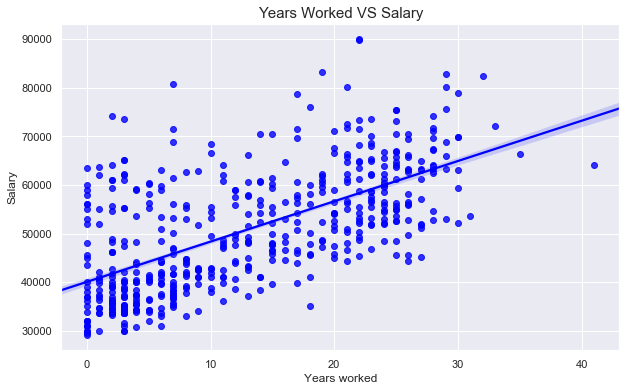

In [11]:
sns.set()
plt.figure(figsize = (10,6))
sns.regplot(data = salary_data, x = salary_data["yearsworked"], y =salary_data["salary"],ci = 68,color = "blue")
plt.xlabel("Years worked", fontsize = 12)
plt.ylabel("Salary", fontsize = 12 )
_= plt.title("Years Worked VS Salary", fontsize = 15)

Text(0, 0.5, 'Frequency')

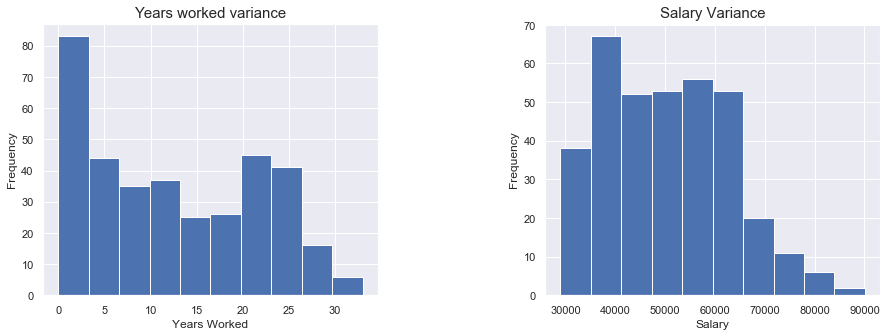

In [12]:
#plotting histogram & subplotting
f, axes = plt.subplots(1, 2,figsize=(15, 5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)
plt.subplot(grid[0, 0])
x_train.hist()
plt.title('Years worked variance', fontsize= 15)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')

plt.subplot(grid[0, 1])
y_train.hist()
plt.title('Salary Variance', fontsize= 15)
plt.xlabel('Salary')
plt.ylabel('Frequency')

In [13]:
#Creating training target
y = salary_data["salary"]
 
#Creating testin target    
x = salary_data[["yearsworked"]]

X = sm.add_constant(x.values)

#Slipping data into training and testing set wit an 80-20
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)


# create a fitted model in one line
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)

### 2. The statsmodels package and the training data, running a simple linear regression for Salary with one predictor variable: Years Worked

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     308.4
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           8.61e-52
Time:                        03:55:14   Log-Likelihood:                -4329.9
No. Observations:                 409   AIC:                             8664.
Df Residuals:                     407   BIC:                             8672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.939e+04    807.405     48.783      0.000    3.78e+04     4.1e+04
x1           897.5084     51.111     17.560      0.000     797.035     997.982
==============================================================================
Omnibus:                       57.739   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.002
Skew:                           0.996   Prob(JB):                     7.00e-18
Kurtosis:                       3.819   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Reporting the amount of variance explained (R^2) and significance value (p) 

In [15]:
print('R-squared: ', model.rsquared)


R-squared:  0.43105483946599843


In [16]:
print('P-value: ', model.pvalues)

P-value:  const    4.017975e-172
x1        8.610876e-52
dtype: float64



R-squared is 0.4311 this means is 43.11, this indicates that the variables are closely related to each other.

A p-value weighs the strength of the evidence (i.e what the data tells you about the population). A value of <0.05 implies significance and that of <0.01 implies high significance. Therefore, our p-value being =0.000 implies high significance. Therefore we can conclude that it is statistically significan

## 3. What the unstandardized coefficient (B or ‘coef’ in statsmodels) tells about the relationship between Years Worked and Salary.

An unstandardized coefficient represents the amount of change in a dependent variable Y due to a change of 1 unit of independent variable X. So in our case is true the salary does increase with years worked when we look at our graphs above

## 4. 95% confidence intervals [0.025, 0.975] means:
Our coefficients fall within the confidence interval range. Although we dont have 100% certainty, we are 95% confident that the values are valid.

## 5. The expected salary for someone with 12 years’ work experience.

In [17]:
model.predict([1,12])

array([50157.98525943])

The salary of someone with 12 years experience will be appox = 50158

## 6. The expected salary for someone with 80 years’ work experience.

In [18]:
model.predict([1,80])

array([111188.55539573])

Salary for someone over 80 years is apporox = 111189

* It is very unlikely for a person to work for 80 years

## 7.  Other employee characteristics might influence their salary

According to the correlation tablt above in Question 1, years ranked and position occupied are moderatly - strongly correlated to salary recieved.

root mean squared error for train =  9581.63412623038
root mean squared error for test =  9814.410713773967
root mean squared error difference =  232.77658754358708


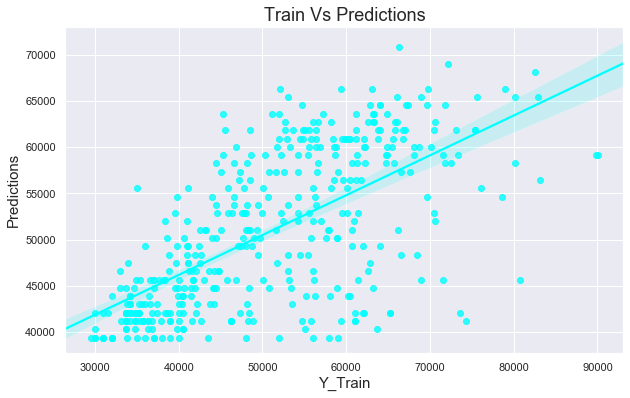

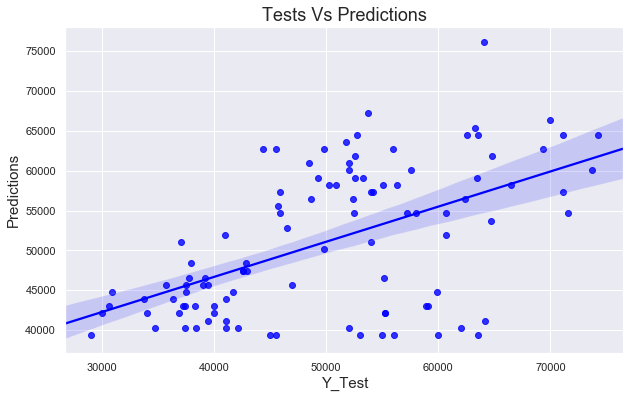

In [21]:
# Root Mean Square Error for train
train_rmse = rmse(y_train, model.predict(X_train))
print('root mean squared error for train = ', train_rmse)

#Root Mean Square Error for test
test_rmse = rmse(y_test, predictions)
print('root mean squared error for test = ', test_rmse)

# Root Mean Square Error difference 
rmse_diff = test_rmse - train_rmse
print('root mean squared error difference = ', rmse_diff)

#Regression plot for train
sns.set()
plt.figure(figsize = (10,6))
sns.regplot(y_train, model.predict(X_train), color = "cyan")
plt.xlabel("Y_Train",fontsize = 15)
plt.ylabel("Predictions", fontsize = 15)
_= plt.title("Train Vs Predictions",fontsize = 18)


#Regression plot for tests
sns.set()
plt.figure(figsize = (10,6))
sns.regplot(y_test,predictions, color = "blue")
plt.xlabel("Y_Test",fontsize = 15)
plt.ylabel("Predictions", fontsize = 15)
_= plt.title("Tests Vs Predictions",fontsize = 18)